In [4]:
#This code gives you the stats for all models in the BCS_CNN folder, currently, it gives: Accuracy, precision, recall, F1 score, and MSE

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image as pil_image
import imageio
import tensorflow
import sklearn.metrics
import itertools
#physical_devices = tensorflow.config.experimental.list_physical_devices('GPU')
#tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)
#from keras.applications.vgg16 import preprocess_input
from astropy.io import fits
import skimage.transform
# import keras
# from keras.layers import Input
# import keras.applications
# from keras.models import Model
# from keras.layers import Dense, Flatten, Dropout, Conv2D, ReLU, concatenate, MaxPool2D, AvgPool2D
import glob
# from keras.models import load_model
# from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.vgg16 import preprocess_input
# from keras.applications.vgg16 import decode_predictions
from tensorflow.keras.optimizers import Adam
import sklearn.metrics
import csv

import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics
import torch
from torch import nn
from sklearn.utils import class_weight
import pandas as pd
import numpy as np
from datasets import load_dataset
model_type = 'VIT_models'


def normalize_Xtrain(X_train):
    mn = []
    mx = []
    Xn_train = np.zeros(np.shape(X_train))
    X_norm = np.zeros(np.shape(X_train))
    for i in range(len(X_train[0, ::])):
        mn.append(np.min(X_train[::, i]))
        Xn_train[::, i] = X_train[::, i] - mn[i]
    for i in range(len(X_train[0, ::])):
        mx.append(np.max(Xn_train[::, i]))
        if mx[i] == 0:
            X_norm[::, i] = 0
        if mx[i] != 0:
            X_norm[::, i] = Xn_train[::, i]/mx[i]
            
    return X_norm, mx, mn

with open(model_type+'_stats.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Model', 'Accuracy', 'Precision', 'Weighted Precision', 'Recall', 'Weighted Recall', 'F1 Score', 'Weighted F1 Score', 'MSE'])

with open(model_type+'_stats_within_1.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Model', 'Accuracy', 'Precision', 'Weighted Precision', 'Recall', 'Weighted Recall', 'F1 Score', 'Weighted F1 Score', 'MSE'])

In [5]:
import pytorch_lightning as pl
from transformers import BeitForImageClassification, AdamW
import torch.nn as nn

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from transformers import BeitFeatureExtractor



feature_extractor = BeitFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
test_ds = load_dataset("DGE_test_mixed", data_dir="*/", split="train")

#For testing with a 70/30 split, use the below code, requires manually sorting the dataset into train/test/val splits:
#test_ds = load_dataset("DGE_all_10", data_dir="*/", split="train")

id2label = {id:label for id, label in enumerate(test_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
print(label2id)

from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor,
                                    RandomRotation)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [   
            #Resize(feature_extractor.size),
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples


trainer = Trainer(accelerator='gpu', devices=1,# callbacks=[early_stop_callback],#, checkpoint],
        check_val_every_n_epoch=1, 
        max_epochs=5,
        min_epochs=0,
        )

test_ds.set_transform(val_transforms)

from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_batch_size = 16
eval_batch_size = 8

test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=train_batch_size)

batch = next(iter(test_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

assert batch['pixel_values'].shape == (train_batch_size, 3, 224, 224)
assert batch['labels'].shape == (train_batch_size,)


class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=10):
        super(ViTLightningModule, self).__init__()
        self.vit = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224",
                                                              num_labels=5,
                                                              id2label=id2label,
                                                              label2id=label2id,
                                                              ignore_mismatched_sizes=True)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        #criterion = nn.CrossEntropyLoss()
        criterion = nn.CrossEntropyLoss(weight=torch.cuda.FloatTensor(class_weights))
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_accuracy", accuracy, on_epoch=True)

        return loss, accuracy

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=1e-5)

    # def train_dataloader(self):
    #     return train_dataloader

    # def val_dataloader(self):
    #     return val_dataloader
    
    def test_dataloader(self):
        return test_dataloader
    
    def predict_dataloader(self):
        return test_dataloader

Resolving data files: 100%|██████████| 760/760 [00:00<00:00, 379936.95it/s]
Using custom data configuration DGE_test_mixed-a8780ea480b8e1de
Reusing dataset imagefolder (C:\Users\zacha\.cache\huggingface\datasets\imagefolder\DGE_test_mixed-a8780ea480b8e1de\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


{'2': 0, '3': 1, '4': 2, '5': 3, '6': 4}
pixel_values torch.Size([16, 3, 224, 224])
labels torch.Size([16])


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_0.19_2 -------------------------------------------------------

The accuracy of  BEiT_0.19_2  is:  0.19210526315789472

Model precision is:  0.18555427566888527
Model weighted precision is:  0.34334108524042356

Model recall is:  0.2730878774363669
Model weighted recall is:  0.19210526315789472

Model f1_score is:  0.14147177667708805
Model weighted f1_score is:  0.2018906523751729

Model MSE is:  2.475

****Error within 1 results starts now****

The accuracy of  BEiT_0.19_2  within 1 is:  0.6723684210526316

Model unweighted precision is:  0.6381743066953453
Model weighted precision is:  0.819088327699379

Model unweighted recall is:  0.7504477811771069
Model weighted recall is:  0.6723684210526316

Model unweighted f1_score is:  0.5883722064413958
Model weighted f1_score is:  0.7119643561449466



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_0.22_1. -------------------------------------------------------

The accuracy of  BEiT_0.22_1.  is:  0.21578947368421053

Model precision is:  0.4172422967501741
Model weighted precision is:  0.4213273312950006

Model recall is:  0.2567241944416189
Model weighted recall is:  0.21578947368421053

Model f1_score is:  0.16755711802206116
Model weighted f1_score is:  0.2323594391051666

Model MSE is:  1.175

****Error within 1 results starts now****

The accuracy of  BEiT_0.22_1.  within 1 is:  0.9210526315789473

Model unweighted precision is:  0.918719231800279
Model weighted precision is:  0.929499177331987

Model unweighted recall is:  0.7663020538554564
Model weighted recall is:  0.9210526315789473

Model unweighted f1_score is:  0.7839447998604407
Model weighted f1_score is:  0.9168930276763203



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_0.23_2 -------------------------------------------------------

The accuracy of  BEiT_0.23_2  is:  0.23026315789473684

Model precision is:  0.34074040946133966
Model weighted precision is:  0.34808697261191135

Model recall is:  0.24870925478188224
Model weighted recall is:  0.23026315789473684

Model f1_score is:  0.14590071967004906
Model weighted f1_score is:  0.20730231645805602

Model MSE is:  2.463157894736842

****Error within 1 results starts now****

The accuracy of  BEiT_0.23_2  within 1 is:  0.5513157894736842

Model unweighted precision is:  0.5480396229472774
Model weighted precision is:  0.5471151747586204

Model unweighted recall is:  0.571436192595027
Model weighted recall is:  0.5513157894736842

Model unweighted f1_score is:  0.4928769559102745
Model weighted f1_score is:  0.5074089148572735



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_0.28_2 -------------------------------------------------------

The accuracy of  BEiT_0.28_2  is:  0.28289473684210525

Model precision is:  0.21660575968222445
Model weighted precision is:  0.2944027204306695

Model recall is:  0.3123844684570959
Model weighted recall is:  0.28289473684210525

Model f1_score is:  0.19279775855582515
Model weighted f1_score is:  0.26860829177107476

Model MSE is:  2.7302631578947367

****Error within 1 results starts now****

The accuracy of  BEiT_0.28_2  within 1 is:  0.44473684210526315

Model unweighted precision is:  0.5546855411183527
Model weighted precision is:  0.515672041836086

Model unweighted recall is:  0.5376325281879142
Model weighted recall is:  0.44473684210526315

Model unweighted f1_score is:  0.46196169370660634
Model weighted f1_score is:  0.4462342070982398



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_0.2_2 -------------------------------------------------------

The accuracy of  BEiT_0.2_2  is:  0.2013157894736842

Model precision is:  0.3294470447155357
Model weighted precision is:  0.5767553888042506

Model recall is:  0.30658124439784495
Model weighted recall is:  0.2013157894736842

Model f1_score is:  0.20642967864661604
Model weighted f1_score is:  0.2096434587740626

Model MSE is:  2.0223684210526316

****Error within 1 results starts now****

The accuracy of  BEiT_0.2_2  within 1 is:  0.7302631578947368

Model unweighted precision is:  0.7141140766833762
Model weighted precision is:  0.8873364256733147

Model unweighted recall is:  0.662061597406425
Model weighted recall is:  0.7302631578947368

Model unweighted f1_score is:  0.6397843094181977
Model weighted f1_score is:  0.7718549054029487



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_0.33_2 -------------------------------------------------------

The accuracy of  BEiT_0.33_2  is:  0.33026315789473687

Model precision is:  0.14764322766886323
Model weighted precision is:  0.2866698754346468

Model recall is:  0.16667762102611047
Model weighted recall is:  0.3302631578947368

Model f1_score is:  0.15557368669478416
Model weighted f1_score is:  0.3053521670227245

Model MSE is:  2.707894736842105

****Error within 1 results starts now****

The accuracy of  BEiT_0.33_2  within 1 is:  0.5342105263157895

Model unweighted precision is:  0.5537997491162049
Model weighted precision is:  0.5571341928204021

Model unweighted recall is:  0.3959633185449481
Model weighted recall is:  0.5342105263157895

Model unweighted f1_score is:  0.4403515977727688
Model weighted f1_score is:  0.526438639707518



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_0.34_2 -------------------------------------------------------

The accuracy of  BEiT_0.34_2  is:  0.3447368421052632

Model precision is:  0.21324062841066715
Model weighted precision is:  0.3850617807776201

Model recall is:  0.20352185916345208
Model weighted recall is:  0.3447368421052632

Model f1_score is:  0.2031486730305963
Model weighted f1_score is:  0.3621474084257761

Model MSE is:  2.419736842105263

****Error within 1 results starts now****

The accuracy of  BEiT_0.34_2  within 1 is:  0.6394736842105263

Model unweighted precision is:  0.6541993972877951
Model weighted precision is:  0.7338659692299558

Model unweighted recall is:  0.5033578697943971
Model weighted recall is:  0.6394736842105263

Model unweighted f1_score is:  0.5397165218713557
Model weighted f1_score is:  0.6735619308261688



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_0.38_1. -------------------------------------------------------

The accuracy of  BEiT_0.38_1.  is:  0.37894736842105264

Model precision is:  0.37984862449378576
Model weighted precision is:  0.47104087381209625

Model recall is:  0.24207717259288816
Model weighted recall is:  0.37894736842105264

Model f1_score is:  0.2684044018537871
Model weighted f1_score is:  0.395166854384779

Model MSE is:  1.3855263157894737

****Error within 1 results starts now****

The accuracy of  BEiT_0.38_1.  within 1 is:  0.8131578947368421

Model unweighted precision is:  0.7249658387589422
Model weighted precision is:  0.8463353872382909

Model unweighted recall is:  0.6309812758698935
Model weighted recall is:  0.8131578947368421

Model unweighted f1_score is:  0.6693775453432736
Model weighted f1_score is:  0.8206825399846562



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_0.38_ -------------------------------------------------------

The accuracy of  BEiT_0.38_  is:  0.38421052631578945

Model precision is:  0.20529408760434875
Model weighted precision is:  0.31320183755598585

Model recall is:  0.2645850775542567
Model weighted recall is:  0.38421052631578945

Model f1_score is:  0.22549978801233755
Model weighted f1_score is:  0.3376449962597509

Model MSE is:  2.401315789473684

****Error within 1 results starts now****

The accuracy of  BEiT_0.38_  within 1 is:  0.5302631578947369

Model unweighted precision is:  0.5241123724343538
Model weighted precision is:  0.5146032746123995

Model unweighted recall is:  0.4503302391614873
Model weighted recall is:  0.5302631578947369

Model unweighted f1_score is:  0.4675493798100495
Model weighted f1_score is:  0.4994748554514306



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_0.38_ -------------------------------------------------------

The accuracy of  BEiT_0.38_  is:  0.37894736842105264

Model precision is:  0.2423536784058153
Model weighted precision is:  0.3272384746802462

Model recall is:  0.19618031918916873
Model weighted recall is:  0.37894736842105264

Model f1_score is:  0.19885721180364038
Model weighted f1_score is:  0.33985817433303334

Model MSE is:  2.8039473684210527

****Error within 1 results starts now****

The accuracy of  BEiT_0.38_  within 1 is:  0.4881578947368421

Model unweighted precision is:  0.5375589681822744
Model weighted precision is:  0.5024789748384814

Model unweighted recall is:  0.3678474770632231
Model weighted recall is:  0.4881578947368421

Model unweighted f1_score is:  0.4071355207569568
Model weighted f1_score is:  0.47208823064057553



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
<ipython-input-6-526508651081>:130: RuntimeWarning: More than 20 figures ha

Beginning of results for  BEiT_0.3_2 -------------------------------------------------------

The accuracy of  BEiT_0.3_2  is:  0.3

Model precision is:  0.38761483722910073
Model weighted precision is:  0.39620911307125184

Model recall is:  0.2686223567174132
Model weighted recall is:  0.3

Model f1_score is:  0.20015445642976007
Model weighted f1_score is:  0.28359901072718036

Model MSE is:  2.825

****Error within 1 results starts now****

The accuracy of  BEiT_0.3_2  within 1 is:  0.4486842105263158

Model unweighted precision is:  0.5405679356102309
Model weighted precision is:  0.49774261243441587

Model unweighted recall is:  0.4751529589376706
Model weighted recall is:  0.4486842105263158

Model unweighted f1_score is:  0.4551519543459495
Model weighted f1_score is:  0.45235044753556614



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_0.41_1 -------------------------------------------------------

The accuracy of  BEiT_0.41_1  is:  0.41578947368421054

Model precision is:  0.21303632716313473
Model weighted precision is:  0.3515835433682749

Model recall is:  0.26498786761221915
Model weighted recall is:  0.41578947368421054

Model f1_score is:  0.21342980269141792
Model weighted f1_score is:  0.35653833656855716

Model MSE is:  1.8855263157894737

****Error within 1 results starts now****

The accuracy of  BEiT_0.41_1  within 1 is:  0.6605263157894737

Model unweighted precision is:  0.6578476927061833
Model weighted precision is:  0.6864450092115808

Model unweighted recall is:  0.5747789892777686
Model weighted recall is:  0.6605263157894737

Model unweighted f1_score is:  0.5687406522935279
Model weighted f1_score is:  0.6096044108540114



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_0.46_1 -------------------------------------------------------

The accuracy of  BEiT_0.46_1  is:  0.45789473684210524

Model precision is:  0.24369772686882457
Model weighted precision is:  0.374190710559246

Model recall is:  0.29393884859249525
Model weighted recall is:  0.45789473684210524

Model f1_score is:  0.2465312813479937
Model weighted f1_score is:  0.3817755097616976

Model MSE is:  1.7473684210526317

****Error within 1 results starts now****

The accuracy of  BEiT_0.46_1  within 1 is:  0.6421052631578947

Model unweighted precision is:  0.6582561978472117
Model weighted precision is:  0.6636974449187188

Model unweighted recall is:  0.6796346721125482
Model weighted recall is:  0.6421052631578947

Model unweighted f1_score is:  0.5899086777335751
Model weighted f1_score is:  0.5739072572134707



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_0.47_2 -------------------------------------------------------

The accuracy of  BEiT_0.47_2  is:  0.46578947368421053

Model precision is:  0.2415861707700367
Model weighted precision is:  0.35557806512089546

Model recall is:  0.2685630749408595
Model weighted recall is:  0.46578947368421053

Model f1_score is:  0.24413940333414916
Model weighted f1_score is:  0.3888122021930899

Model MSE is:  2.1842105263157894

****Error within 1 results starts now****

The accuracy of  BEiT_0.47_2  within 1 is:  0.6105263157894737

Model unweighted precision is:  0.5762167419144163
Model weighted precision is:  0.5711993861741413

Model unweighted recall is:  0.5034787698428224
Model weighted recall is:  0.6105263157894737

Model unweighted f1_score is:  0.510138484250067
Model weighted f1_score is:  0.5545570026392135



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_0.5_2 -------------------------------------------------------

The accuracy of  BEiT_0.5_2  is:  0.5013157894736842

Model precision is:  0.28214058668604125
Model weighted precision is:  0.484508374400719

Model recall is:  0.26124799713447866
Model weighted recall is:  0.5013157894736842

Model f1_score is:  0.25498091081186836
Model weighted f1_score is:  0.48419172418311845

Model MSE is:  2.430263157894737

****Error within 1 results starts now****

The accuracy of  BEiT_0.5_2  within 1 is:  0.6092105263157894

Model unweighted precision is:  0.6436290981745527
Model weighted precision is:  0.6944512823699427

Model unweighted recall is:  0.41506467853736695
Model weighted recall is:  0.6092105263157894

Model unweighted f1_score is:  0.4541098575825407
Model weighted f1_score is:  0.6223684678138313



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_41_k -------------------------------------------------------

The accuracy of  BEiT_41_k  is:  0.41710526315789476

Model precision is:  0.17671814296814295
Model weighted precision is:  0.32554375996810203

Model recall is:  0.23624162882630992
Model weighted recall is:  0.41710526315789476

Model f1_score is:  0.1950810201449588
Model weighted f1_score is:  0.35669833150651564

Model MSE is:  2.4894736842105263

****Error within 1 results starts now****

The accuracy of  BEiT_41_k  within 1 is:  0.5881578947368421

Model unweighted precision is:  0.4771712215179808
Model weighted precision is:  0.5273590852215729

Model unweighted recall is:  0.4567249768958649
Model weighted recall is:  0.5881578947368421

Model unweighted f1_score is:  0.4399557996839816
Model weighted f1_score is:  0.5281168189939809



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_42_keep_t -------------------------------------------------------

The accuracy of  BEiT_42_keep_t  is:  0.2881578947368421

Model precision is:  0.2381779498919186
Model weighted precision is:  0.23410414743181127

Model recall is:  0.4527163768543079
Model weighted recall is:  0.2881578947368421

Model f1_score is:  0.2871969645738404
Model weighted f1_score is:  0.24706214297978277

Model MSE is:  1.7763157894736843

****Error within 1 results starts now****

The accuracy of  BEiT_42_keep_t  within 1 is:  0.6473684210526316

Model unweighted precision is:  0.65183493981861
Model weighted precision is:  0.6544626717552002

Model unweighted recall is:  0.7215780884990528
Model weighted recall is:  0.6473684210526316

Model unweighted f1_score is:  0.614924248906296
Model weighted f1_score is:  0.5714775925376521



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Beginning of results for  BEiT_42_low_ -------------------------------------------------------

The accuracy of  BEiT_42_low_  is:  0.46578947368421053

Model precision is:  0.25067033836696756
Model weighted precision is:  0.3552284968695376

Model recall is:  0.32703841285241964
Model weighted recall is:  0.46578947368421053

Model f1_score is:  0.2738701546426868
Model weighted f1_score is:  0.3911330454175496

Model MSE is:  2.156578947368421

****Error within 1 results starts now****

The accuracy of  BEiT_42_low_  within 1 is:  0.6013157894736842

Model unweighted precision is:  0.5559209775037114
Model weighted precision is:  0.5492302774321896

Model unweighted recall is:  0.5222737011911561
Model weighted recall is:  0.6013157894736842

Model unweighted f1_score is:  0.5081697060676579
Model weighted f1_score is:  0.5404668350947611



Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Beginning of results for  BEiT_64_k -------------------------------------------------------

The accuracy of  BEiT_64_k  is:  0.6434210526315789

Model precision is:  0.37854032759693135
Model weighted precision is:  0.6415963257199603

Model recall is:  0.4022607711347412
Model weighted recall is:  0.6434210526315789

Model f1_score is:  0.3782465167436856
Model weighted f1_score is:  0.6217440489290058

Model MSE is:  1.6513157894736843

****Error within 1 results starts now****

The accuracy of  BEiT_64_k  within 1 is:  0.7842105263157895

Model unweighted precision is:  0.7125451571178575
Model weighted precision is:  0.8509635652558697

Model unweighted recall is:  0.5675717054111928
Model weighted recall is:  0.7842105263157895

Model unweighted f1_score is:  0.6056614610415366
Model weighted f1_score is:  0.7933647704876651



c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


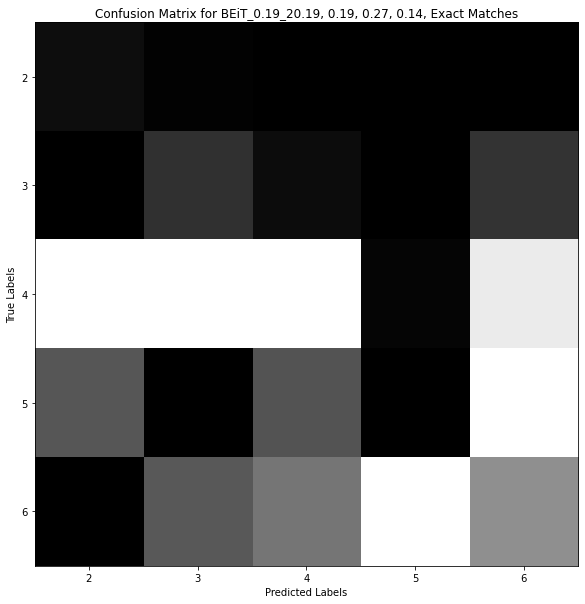

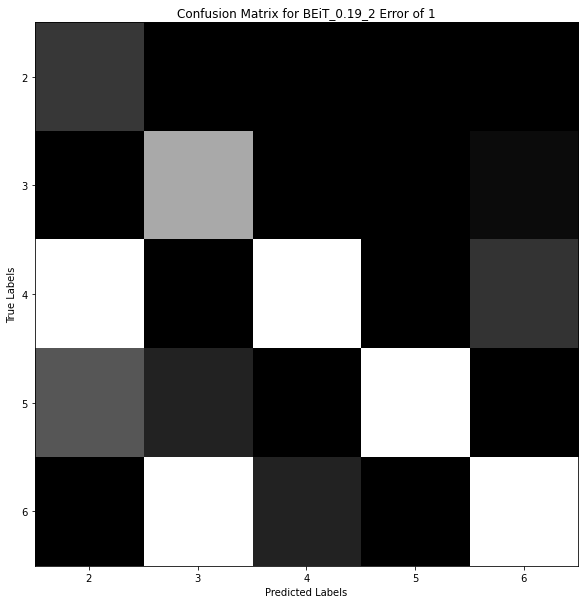

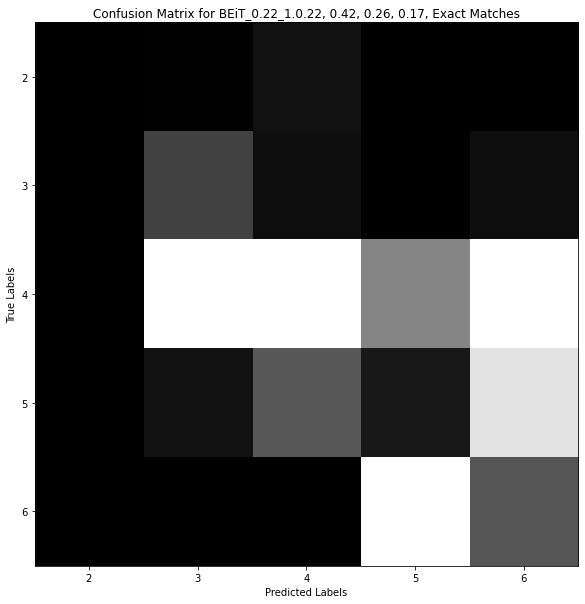

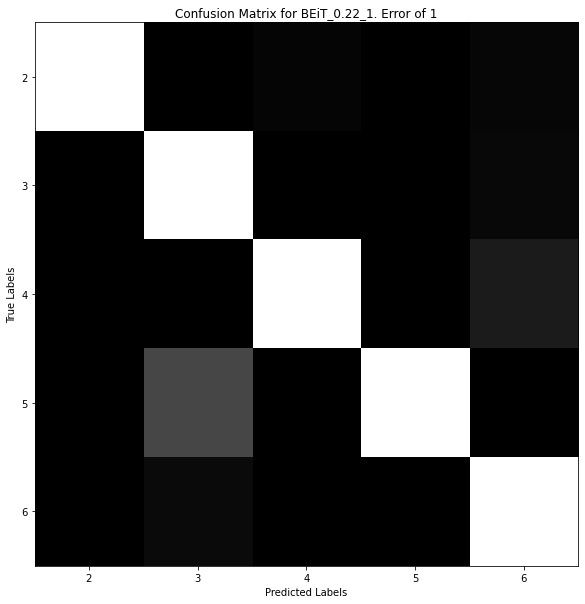

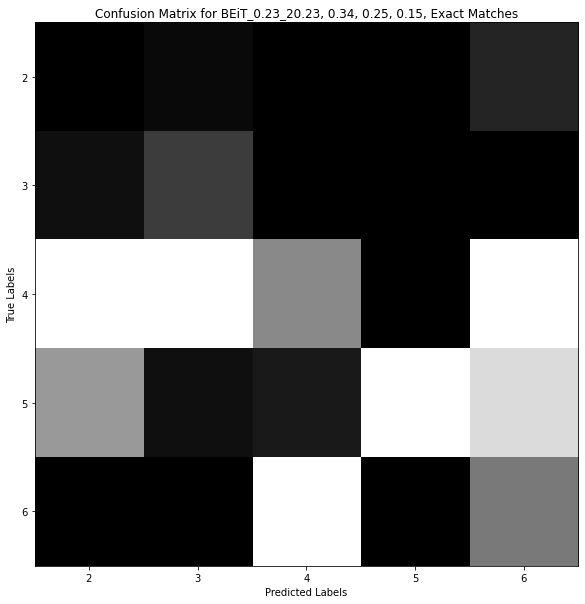

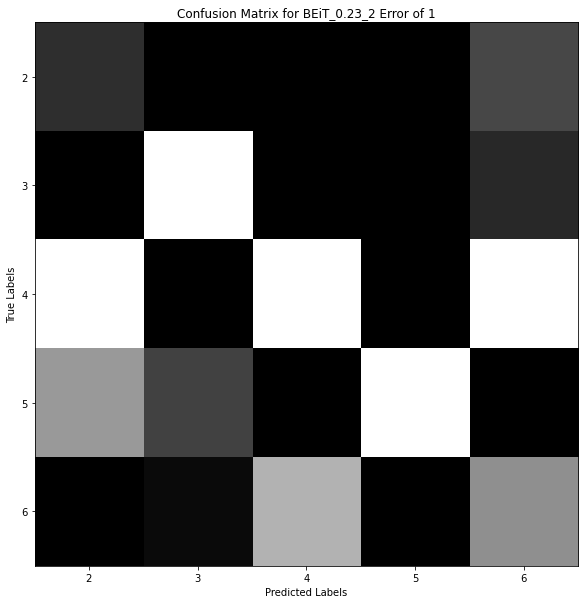

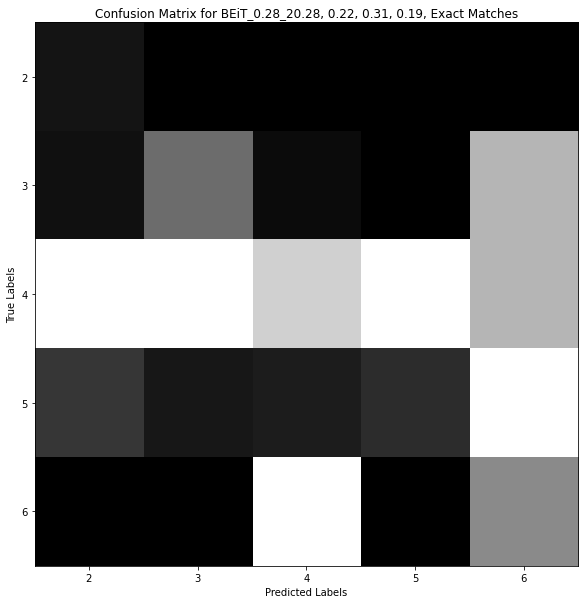

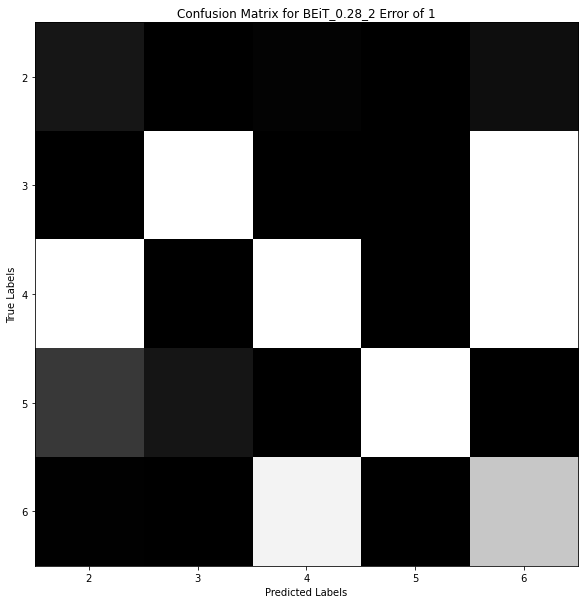

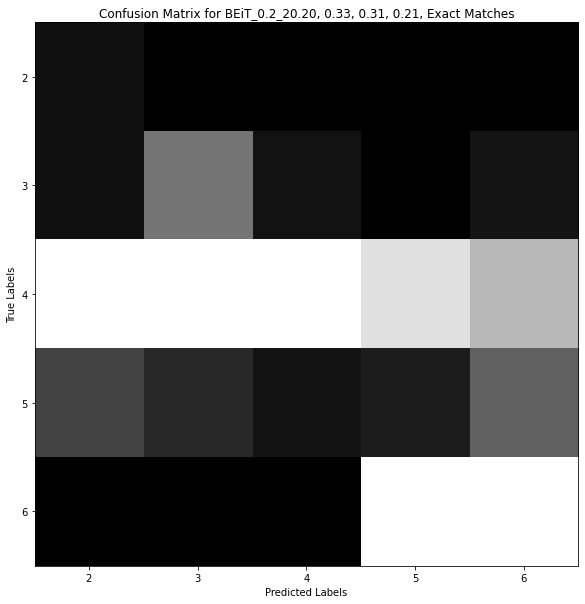

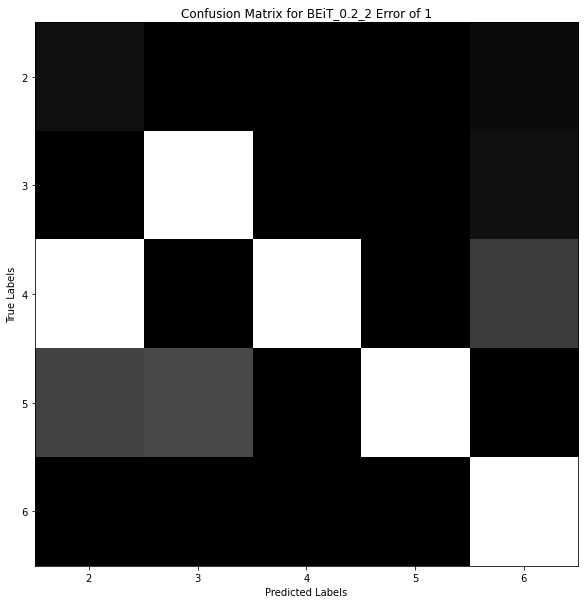

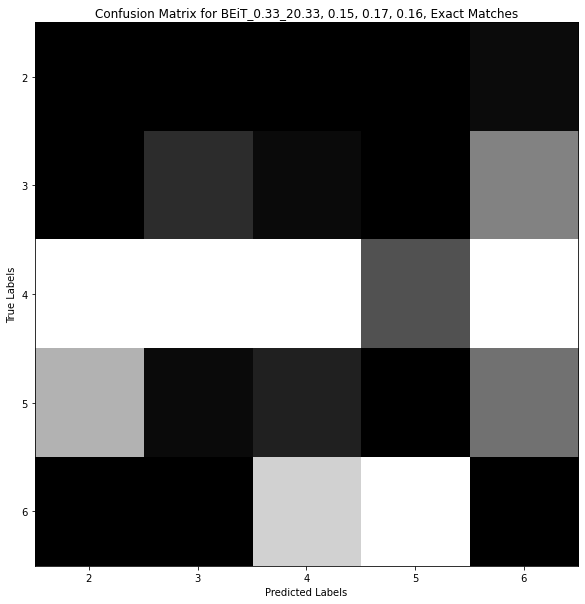

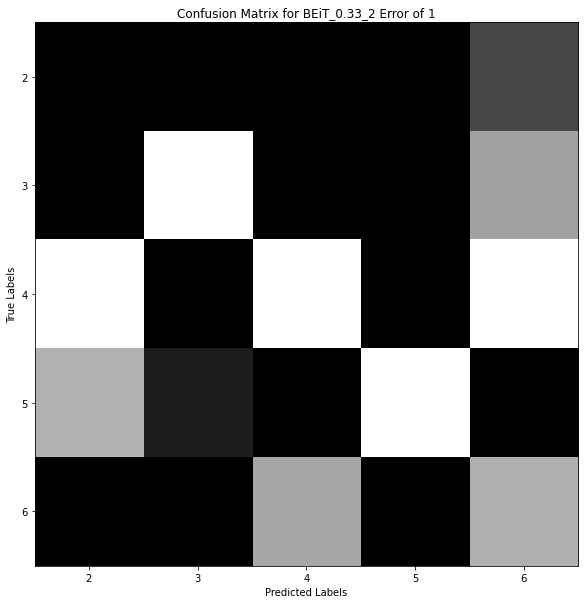

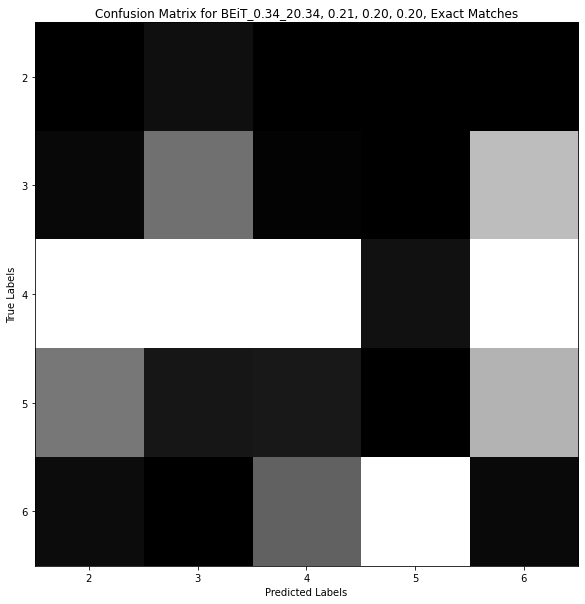

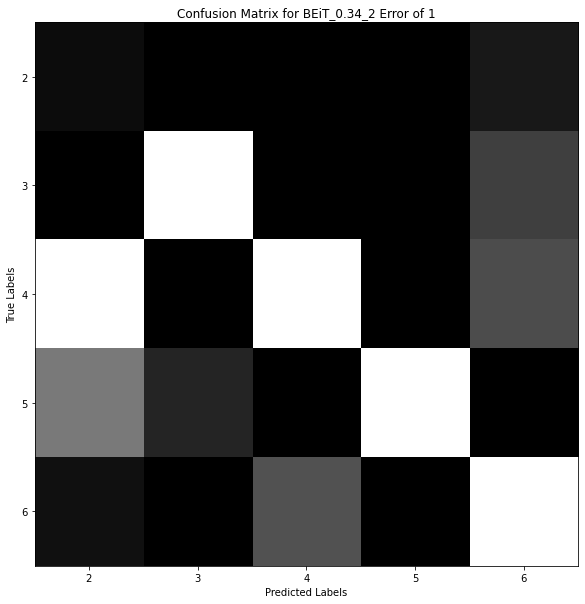

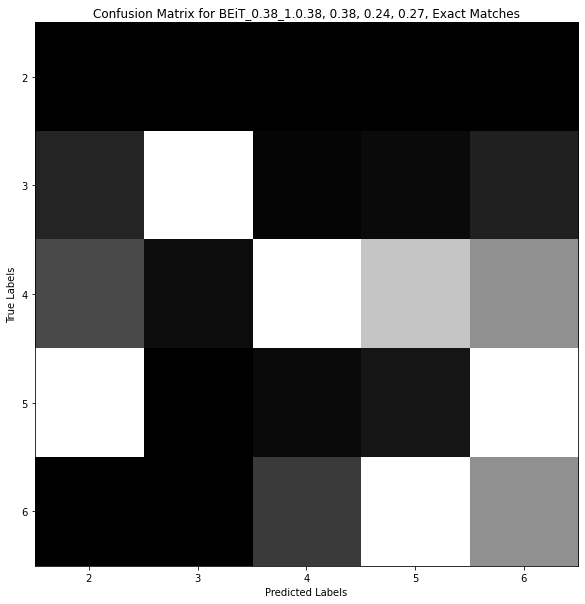

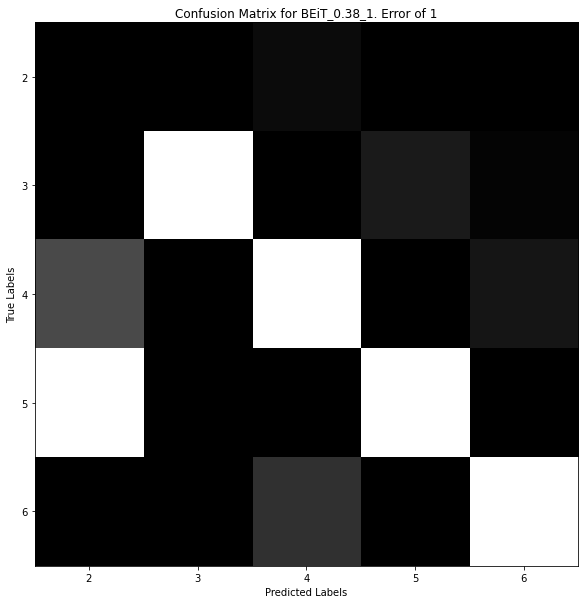

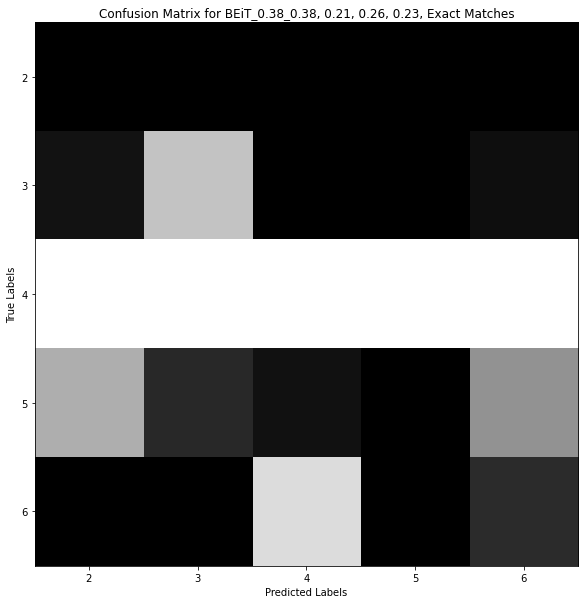

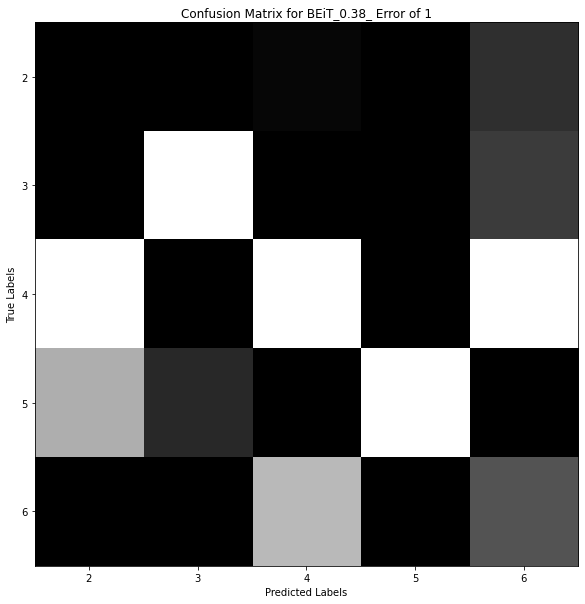

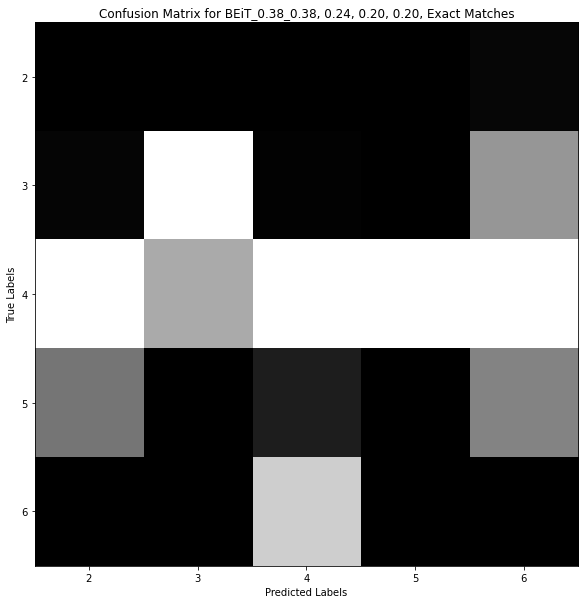

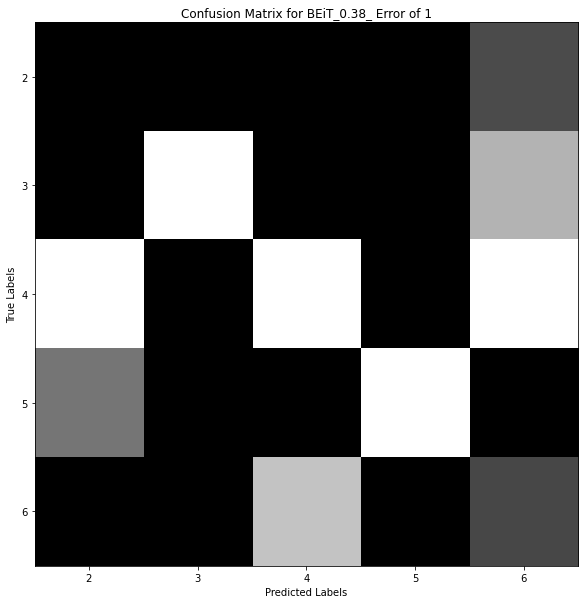

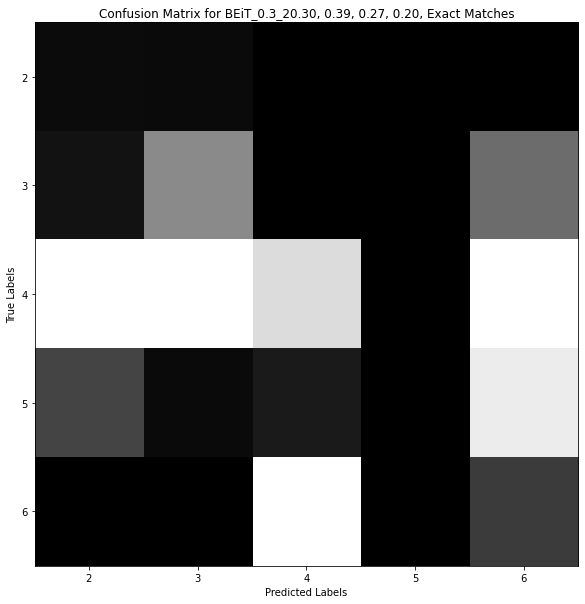

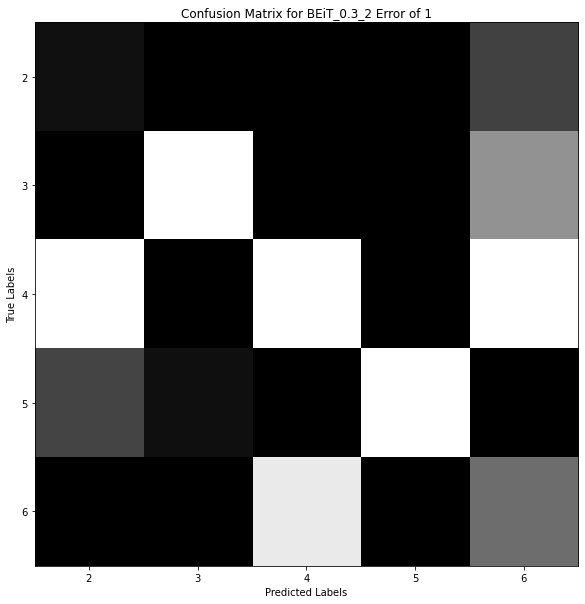

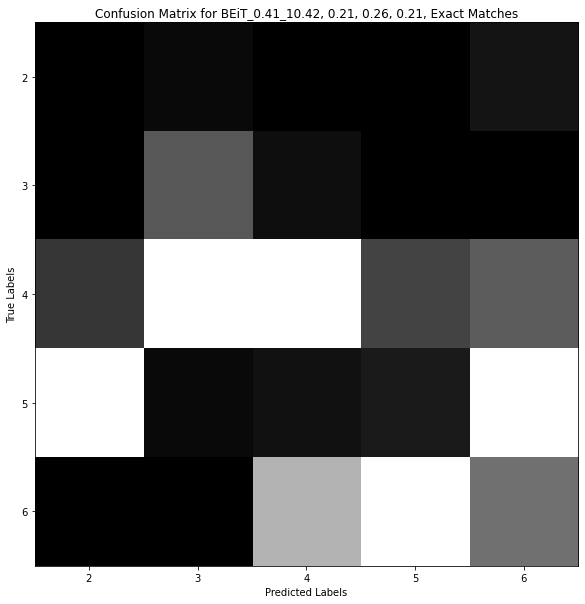

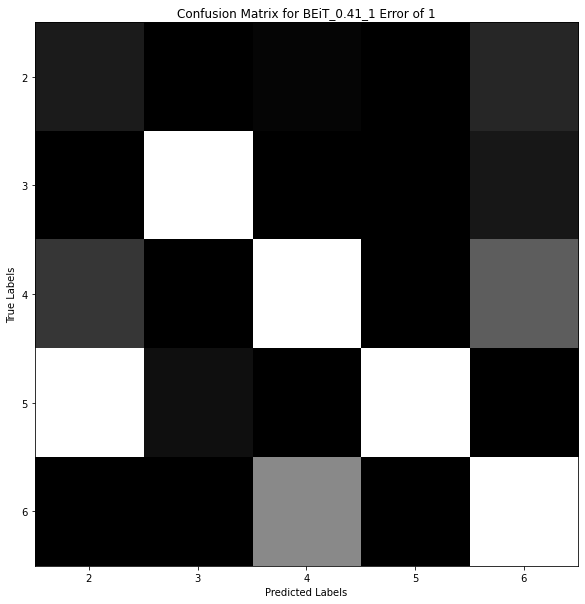

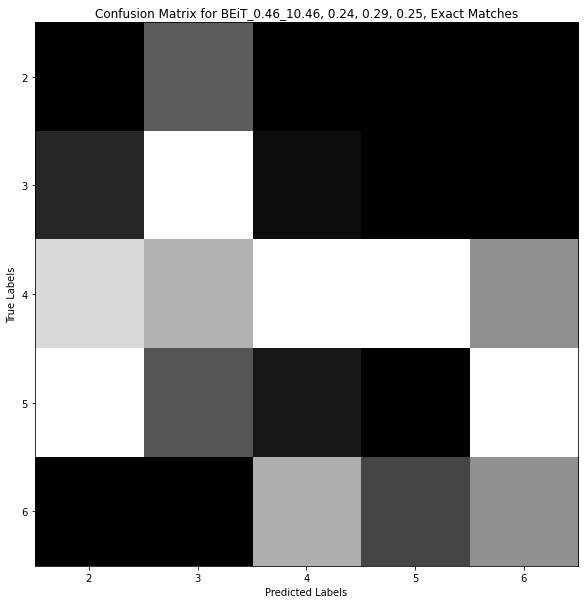

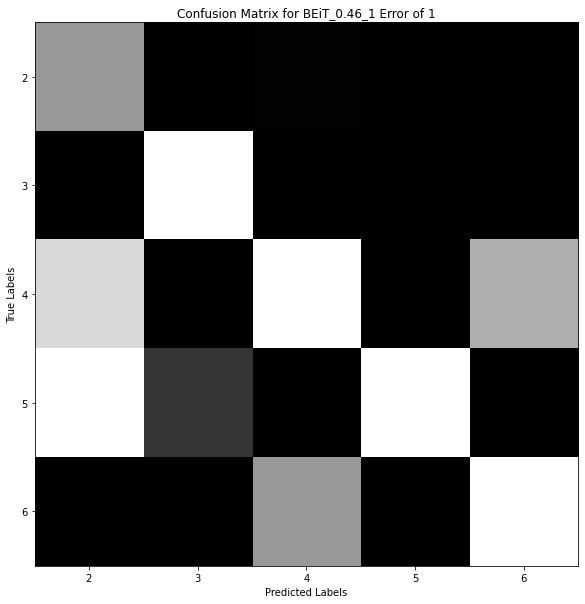

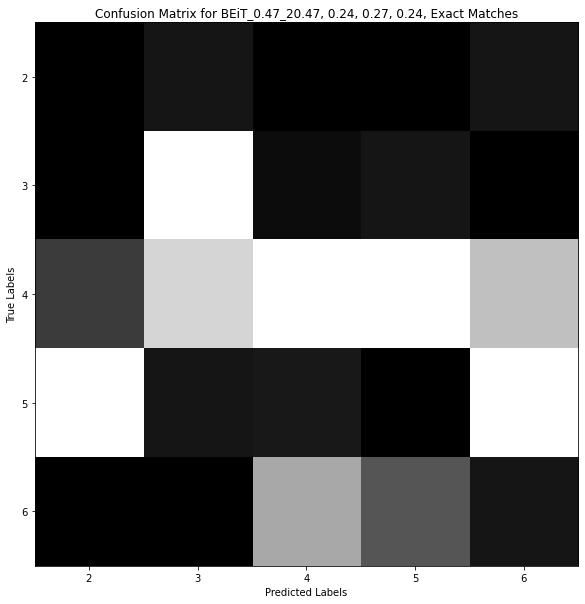

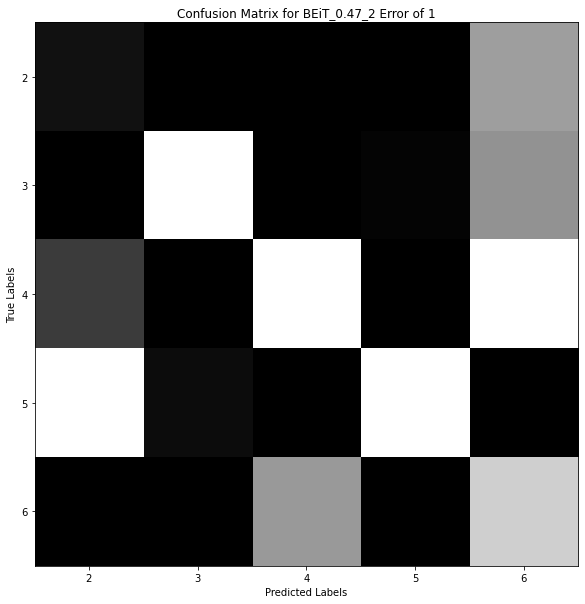

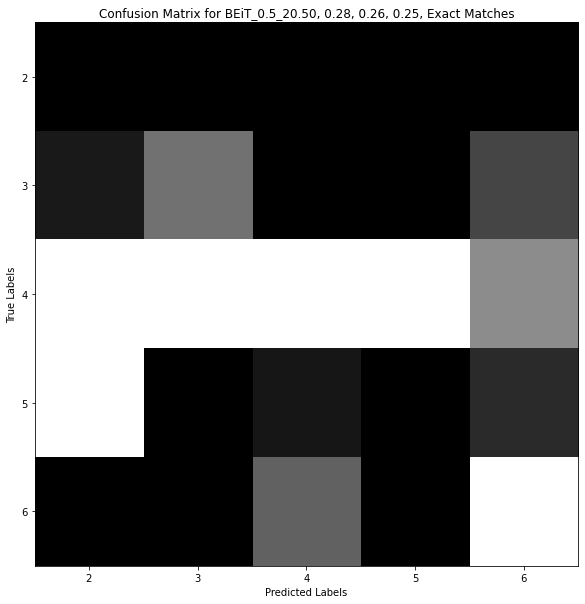

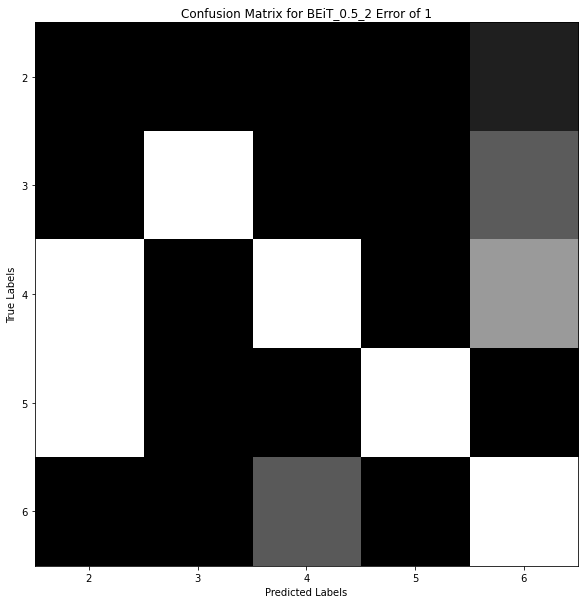

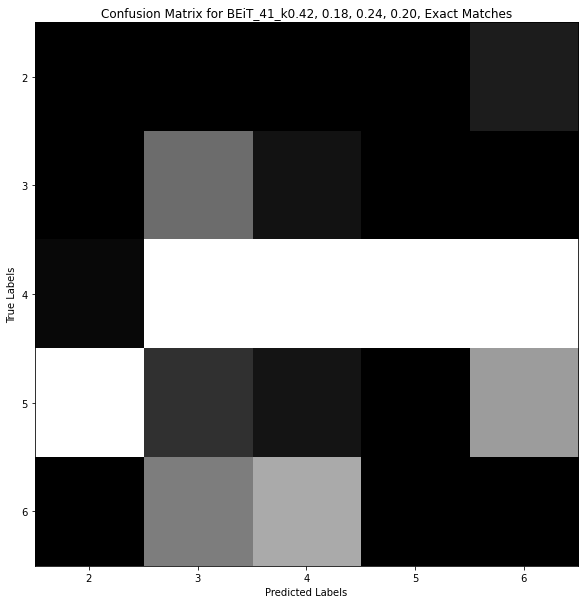

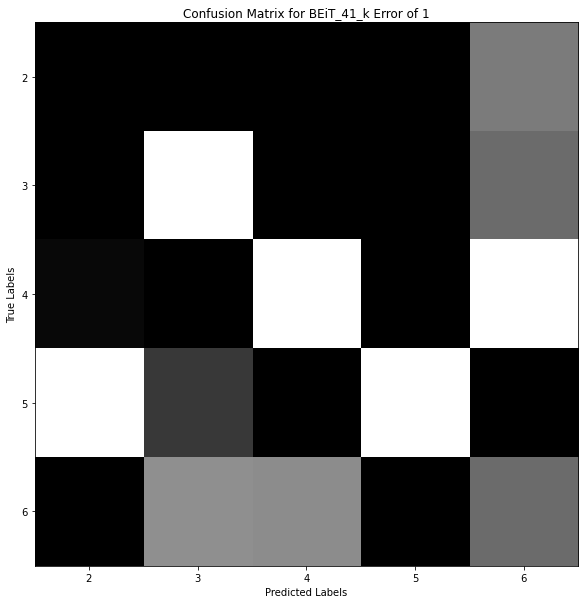

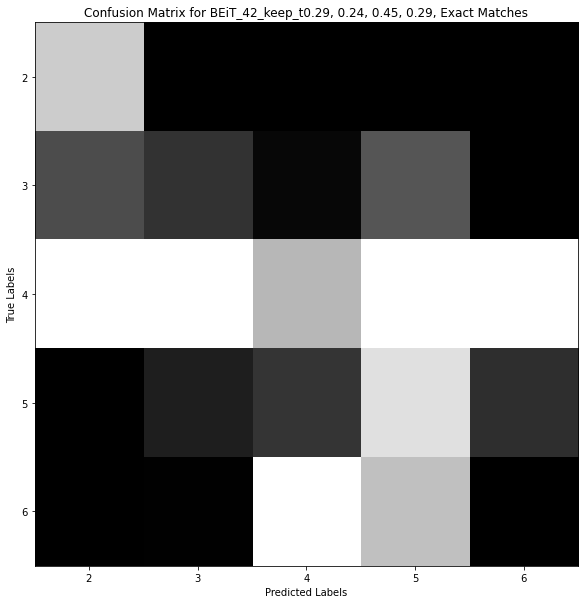

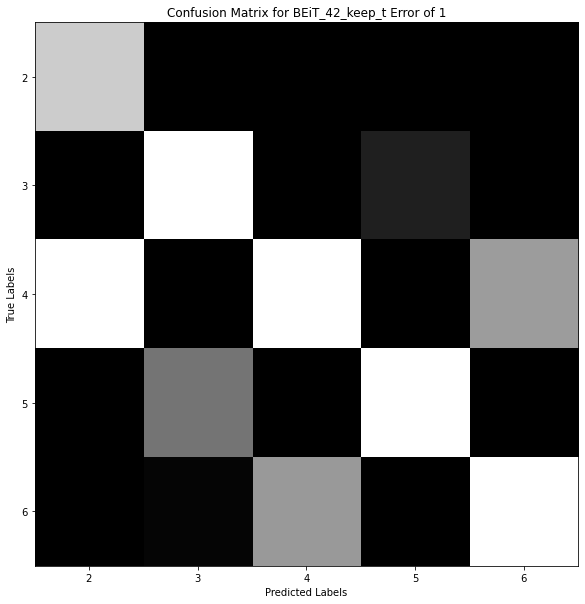

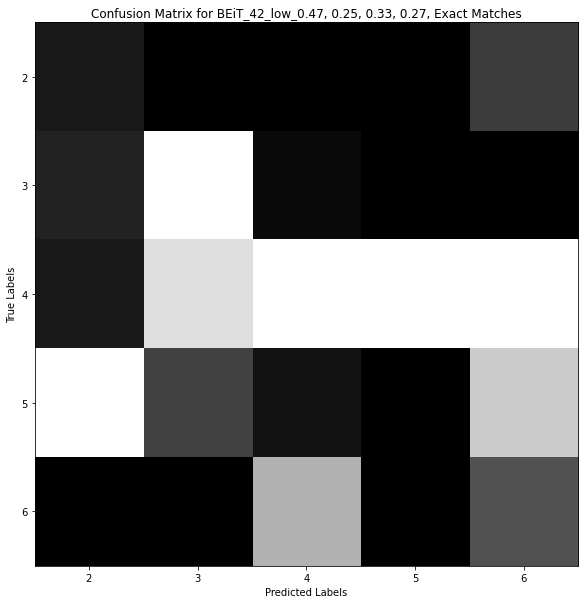

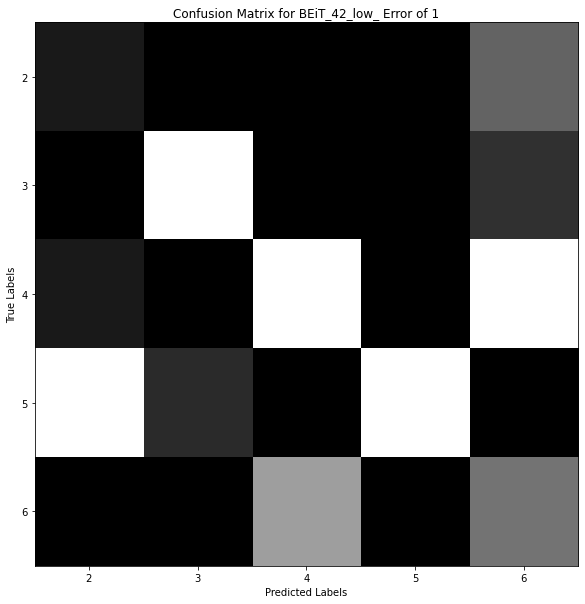

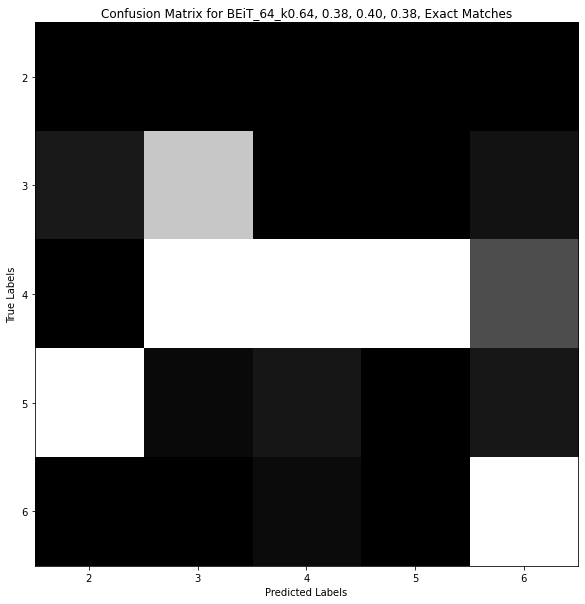

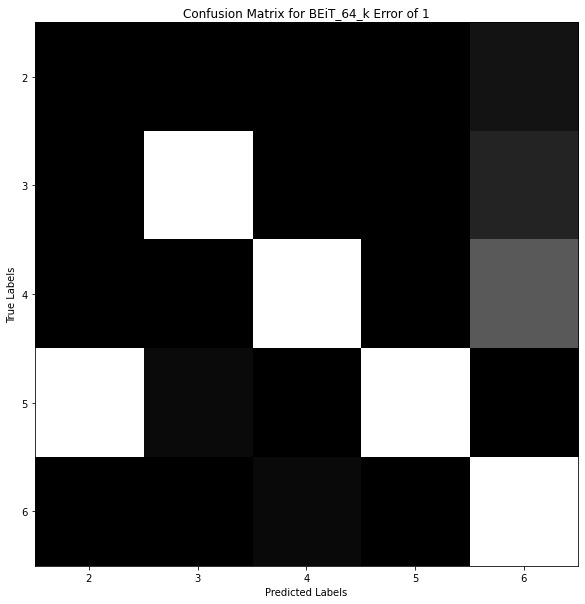

In [6]:
# new_model = ViTLightningModule.load_from_checkpoint(checkpoint_path="VIT_models\BEiT_64_keep.ckpt")
# trainer.test(model=new_model, dataloaders=test_dataloader, verbose=True)

model_names = glob.glob('BCS_CNN\\' + model_type + '\\*')

for model_name in model_names:
    model = ViTLightningModule.load_from_checkpoint(checkpoint_path=model_name)
    #model = load_model(model_name)
    # data_set_type = model_name[len('BCS_CNN\VGG16\VGG16_'):-8] #For VGG16
    # name = str(model_name[len('BCS_CNN\VGG16\\'):-8]) #For VGG16
    # data_set_type = model_name[len('BCS_CNN\SqueezeNet\SqueezeNet_'):-8] #for Squeezenet
    # name = str(model_name[len('BCS_CNN\SqueezeNet\\'):-8]) #For SqueezeNet
    data_set_type = model_name[len('BCS_CNN/' + model_type + '/' + model_type + '_'):-8]
    name = str(model_name[len('BCS_CNN/' + model_type + '/'):-8]) 
    # print(data_set_type)
    # print(name)
    # test_data = 'test_data_' + data_set_type + '.csv'
    # print(test_data)

    #test_df = pd.read_csv(test_data,dtype=str)
    # #test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    # test_datagen = ImageDataGenerator(fill_mode = "reflect", data_format = "channels_last")
    # test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,\
    #                                             directory = '',\
    #                                             xcol='filename',ycol='class',\
    #                                             target_size=(224,224), color_mode='rgb',\
    #                                             batch_size=128, class_mode='categorical',\
    #                                             shuffle=False)

    # train_data = 'train_data_' + data_set_type + '.csv'
    # train_df = pd.read_csv(train_data,dtype=str)
    #train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    # train_datagen = ImageDataGenerator(fill_mode = "reflect", data_format = "channels_last")
    # train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,\
    #                                                 directory='',\
    #                                                 xcol='filename',y_col='class',\
    #                                                 target_size=(224,224), color_mode='rgb',\
    #                                                 batch_size=128, class_mode='categorical',\
    #                                                 shuffle=False)


    # adam_opt = Adam(learning_rate=0.001)
    # model.compile(loss='categorical_crossentropy', optimizer=adam_opt,\
    #            metrics=['categorical_accuracy'])
    # Y_test_hat=model.predict(test_generator)
    # y_test_hat=Y_test_hat.argmax(axis=-1)+2

    # Y_train_hat=model.predict(train_generator)
    # y_train_hat=Y_train_hat.argmax(axis=-1)+2
    y_pred = []
    y_true = []
    model.to('cuda')
    model.eval()
    for batch in test_dataloader:
        labels = batch['labels'].to('cuda')
        outputs = model(batch['pixel_values'].type('torch.cuda.FloatTensor'))
        predictions=np.argmax(outputs.cpu().detach().numpy(), axis=-1)
        y_pred.append(predictions)
        y_true.append(labels.cpu().detach().numpy())

    # y_test = y_true
    # y_test_hat = y_pred

    y_true_total = []
    for i in range(np.shape(y_true)[0]):
        for j in range(len(y_true[i])):
            y_true_total.append(y_true[i][j])

    y_pred_total = []
    for i in range(np.shape(y_pred)[0]):
        for j in range(len(y_pred[i])):
            y_pred_total.append(y_pred[i][j])
    
    y_test = y_true_total
    y_test_hat = y_pred_total
    # y_test = test_df['class']
    # y_test = [int(i) for i in y_test]

    # y_train = train_df['class']
    # y_train = [int(i) for i in y_train]

    print('Beginning of results for ', name, '-------------------------------------------------------')
    print()

    con_matrix = sklearn.metrics.confusion_matrix(y_test,y_test_hat)
    acc=np.diag(con_matrix).sum().astype(float)/con_matrix.sum()

    # con_matrix_train = sklearn.metrics.confusion_matrix(y_train,y_train_hat)
    # acc_train=np.diag(con_matrix_train).sum().astype(float)/con_matrix_train.sum()


    print('The accuracy of ', name,' is: ', acc)
    print()
    # print('The train accuracy of ', name,' is: ', acc_train)
    # print()

    min = np.min(con_matrix)
    max = np.max(con_matrix)
    temp_mat = con_matrix - min
    temp_mat = con_matrix/max


    #Metrics
    precision = sklearn.metrics.precision_score(y_test,y_test_hat, average='macro', zero_division=1)
    print('Model precision is: ', precision)
    precision_weighted = sklearn.metrics.precision_score(y_test,y_test_hat, average='weighted', zero_division=1)
    print('Model weighted precision is: ', precision_weighted)
    print()

    recall = sklearn.metrics.recall_score(y_test,y_test_hat, average='macro')
    print('Model recall is: ', recall)
    recall_weighted = sklearn.metrics.recall_score(y_test,y_test_hat, average='weighted')
    print('Model weighted recall is: ', recall_weighted)
    print()

    f1_score = sklearn.metrics.f1_score(y_test,y_test_hat, average='macro')
    print('Model f1_score is: ', f1_score)
    f1_score_weighted = sklearn.metrics.f1_score(y_test,y_test_hat, average='weighted')
    print('Model weighted f1_score is: ', f1_score_weighted)
    print()


    MSE = sklearn.metrics.mean_squared_error(y_test,y_test_hat)
    print('Model MSE is: ', MSE)
    print()

    print('****Error within 1 results starts now****')
    print()

    plt.figure(figsize=(10,10))
    plt.imshow(normalize_Xtrain(con_matrix)[0], cmap='gray')
    plt.title('Confusion Matrix for '+ name + f'{acc:.2f}, {precision:.2f}, {recall:.2f}, {f1_score:.2f}, Exact Matches')
    plt.xticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
    plt.yticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')


    y_within_1 = []
    for i in range(0, len(y_test)):
        if ((y_test_hat[i] == y_test[i]+1) or (y_test_hat[i] == y_test[i]-1) or (y_test_hat[i] == y_test[i])):
            y_within_1.append(y_test[i])
        else:
            y_within_1.append(y_test_hat[i])


    con_matrix = sklearn.metrics.confusion_matrix(y_test,y_within_1)
    acc_1=np.diag(con_matrix).sum().astype(float)/con_matrix.sum()


    print('The accuracy of ', name, ' within 1 is: ', acc_1)
    print()

    min = np.min(con_matrix)
    max = np.max(con_matrix)
    temp_mat = con_matrix - min
    temp_mat = con_matrix/max

    plt.figure(figsize=(10,10))
    plt.imshow(normalize_Xtrain(con_matrix)[0], cmap='gray')
    plt.title('Confusion Matrix for '+ name + ' Error of 1')
    plt.xticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
    plt.yticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')


    #Metrics
    precision_1 = sklearn.metrics.precision_score(y_test,y_within_1, average='macro', zero_division=1)
    print('Model unweighted precision is: ', precision_1)
    precision_weighted_1 = sklearn.metrics.precision_score(y_test,y_within_1, average='weighted', zero_division=1)
    print('Model weighted precision is: ', precision_weighted_1)
    print()

#print('Avg :', sklearn.metrics.accuracy_score(y_test, y_test_hat, normalize=False))

    recall_1 = sklearn.metrics.recall_score(y_test,y_within_1, average='macro')
    print('Model unweighted recall is: ', recall_1)
    recall_weighted_1 = sklearn.metrics.recall_score(y_test,y_within_1, average='weighted')
    print('Model weighted recall is: ', recall_weighted_1)
    print()

    f1_score_1 = sklearn.metrics.f1_score(y_test,y_within_1, average='macro')
    print('Model unweighted f1_score is: ', f1_score_1)
    f1_score_weighted_1 = sklearn.metrics.f1_score(y_test,y_within_1, average='weighted')
    print('Model weighted f1_score is: ', f1_score_weighted_1)
    print()


    with open(model_type+'_stats.csv', 'a+', newline='') as file:
        writer = csv.writer(file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([name.replace('_', ' '), str(round(acc, 2)), round(precision, 2), round(precision_weighted, 2), round(recall, 2), round(recall_weighted, 2), round(f1_score, 2), round(f1_score_weighted, 2), round(MSE, 2)])

    with open(model_type+'_stats_within_1.csv', 'a+', newline='') as file:
        writer = csv.writer(file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([name.replace('_', ' '), str(round(acc_1, 2)), round(precision_1, 2), round(precision_weighted_1, 2), round(recall_1, 2), round(recall_weighted_1, 2), round(f1_score_1, 2), round(f1_score_weighted_1, 2)])

    # MSE = sklearn.metrics.mean_squared_error(y_test,y_test_hat)
    # print('Model MSE is: ', MSE)
    # print()
    # print()
    # print(model.summary())
    # print()

